In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from src.preprocess import extract_from_adaptive_threshold
from src.cv_cnns import ThreshCNN
from src.train import run_training
from src.data import get_images_annotations, RobotDataset
from src.evaluate import evaluate

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class ThresholdingDataset(RobotDataset):
    def transform(self, image):
        image = extract_from_adaptive_threshold(image)
        return super().transform(image)

In [5]:
dataset = ThresholdingDataset(get_images_annotations('../dataset'))
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
model = ThreshCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
NUM_EPOCHS = 20

In [7]:
train_history, val_history = run_training(model, train_data_loader, val_data_loader, optimizer, criterion, NUM_EPOCHS, device)

Running training for 20 epochs.


Epoch 0: 100%|██████████| 190/190 [00:13<00:00, 13.79it/s, loss=0.118] 


Validation loss=0.11078472285960483


Epoch 1: 100%|██████████| 190/190 [00:13<00:00, 14.38it/s, loss=0.037] 


Validation loss=0.11956996253481886


Epoch 2: 100%|██████████| 190/190 [00:13<00:00, 13.64it/s, loss=0.0423]


Validation loss=0.08207099513432099


Epoch 3: 100%|██████████| 190/190 [00:13<00:00, 14.37it/s, loss=0.0149] 


Validation loss=0.0769993763353035


Epoch 4: 100%|██████████| 190/190 [00:13<00:00, 13.93it/s, loss=0.0368] 


Validation loss=0.08542489471340851


Epoch 5: 100%|██████████| 190/190 [00:13<00:00, 14.01it/s, loss=0.0181] 


Validation loss=0.10817281782100642


Epoch 6: 100%|██████████| 190/190 [00:13<00:00, 13.96it/s, loss=0.00909]


Validation loss=0.08660997328212035


Epoch 7: 100%|██████████| 190/190 [00:13<00:00, 13.88it/s, loss=0.0218] 


Validation loss=0.13401691516081882


Epoch 8: 100%|██████████| 190/190 [00:13<00:00, 14.07it/s, loss=0.004]  


Validation loss=0.11936340136490987


Epoch 9: 100%|██████████| 190/190 [00:12<00:00, 14.68it/s, loss=0.0068] 


Validation loss=0.10579029475385356


Epoch 10: 100%|██████████| 190/190 [00:13<00:00, 13.95it/s, loss=0.00932]


Validation loss=0.15251073434558624


Epoch 11: 100%|██████████| 190/190 [00:13<00:00, 14.19it/s, loss=0.00339]


Validation loss=0.06141513351265174


Epoch 12: 100%|██████████| 190/190 [00:13<00:00, 14.52it/s, loss=0.00366]


Validation loss=0.1533157253812104


Epoch 13: 100%|██████████| 190/190 [00:13<00:00, 14.16it/s, loss=0.00397]


Validation loss=0.10971488918185868


Epoch 14: 100%|██████████| 190/190 [00:13<00:00, 14.32it/s, loss=0.00364]


Validation loss=0.11198780104317665


Epoch 15: 100%|██████████| 190/190 [00:13<00:00, 13.69it/s, loss=0.00247]


Validation loss=0.12176511440238066


Epoch 16: 100%|██████████| 190/190 [00:14<00:00, 13.28it/s, loss=0.00209]


Validation loss=0.22496008743664112


Epoch 17: 100%|██████████| 190/190 [00:13<00:00, 14.32it/s, loss=0.00309] 


Validation loss=0.11243178793195359


Epoch 18: 100%|██████████| 190/190 [00:14<00:00, 12.67it/s, loss=0.00407]


Validation loss=0.07050708996163549


Epoch 19: 100%|██████████| 190/190 [00:13<00:00, 14.13it/s, loss=0.0048]  


Validation loss=0.11295029252140566


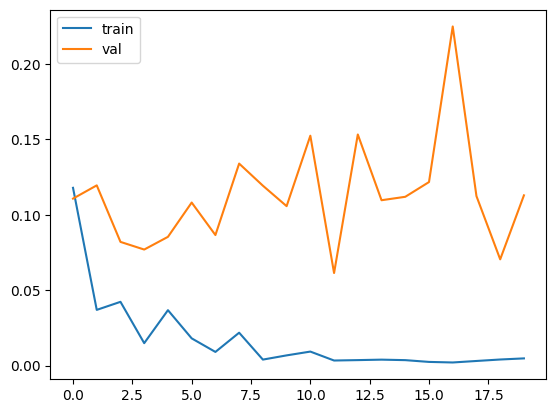

In [8]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

In [9]:
result = evaluate(model, test_data, device)

print(
    f"Vertical MSE: {result['vertical_mse']:.4f}\n"
    f"Horizontal MSE: {result['horizontal_mse']:.4f}\n"
    f"Total MSE: {result['total_mse']:.4f}\n"
)

Vertical MSE: 0.0391
Horizontal MSE: 0.1710
Total MSE: 0.1051



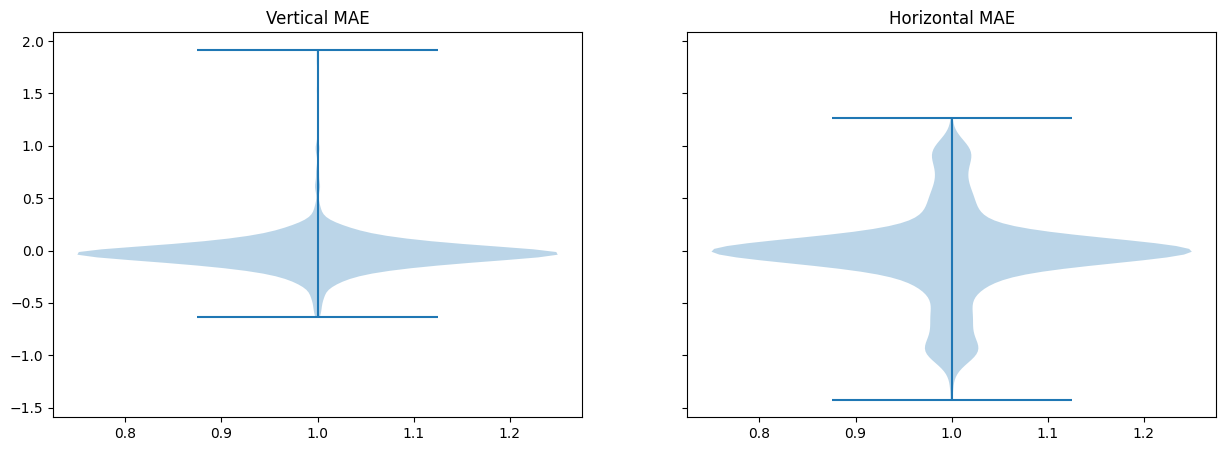

In [10]:
individual_diff = result['individual_prediction_differences']
vertical_diff = individual_diff[:, 0]
horizontal_diff = individual_diff[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.violinplot(vertical_diff)
ax1.set_title('Vertical MAE')
ax2.violinplot(horizontal_diff)
ax2.set_title('Horizontal MAE')

plt.show()

In [11]:
torch.onnx.export(model, torch.randn(1, 1, 224, 224), '../models/thresh_cnn.onnx', verbose=True)

graph(%input.1 : Float(1, 1, 224, 224, strides=[50176, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(2, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %features.2.weight : Float(2, strides=[1], requires_grad=1, device=cpu),
      %features.2.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %features.2.running_mean : Float(2, strides=[1], requires_grad=0, device=cpu),
      %features.2.running_var : Float(2, strides=[1], requires_grad=0, device=cpu),
      %features.3.weight : Float(4, 2, 3, 3, strides=[18, 9, 3, 1], requires_grad=1, device=cpu),
      %features.3.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %features.5.weight : Float(4, strides=[1], requires_grad=1, device=cpu),
      %features.5.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %features.5.running_mean : Float(4, strides=[1], requires_grad=